In [9]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
import models.seqae as seqae
import signal
import seaborn as sns
from tqdm import tqdm
import yaml
from utils import yaml_utils as yu

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1

def load_config(path):
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
    return config 

def load_model(model, log_dir, iters):
    model.load_state_dict(torch.load(os.path.join(
        log_dir, 'snapshot_model_iter_{}'.format(iters)), map_location=device))
    
def save_images(images_cond, images_true, images_pred, images_pred_perm, fname, n_col=3):
    T = images_cond.shape[1] + images_true.shape[1]
    with torch.no_grad():
        model.eval()
        images_pred = torch.cat([torch.ones_like(images_cond), images_pred[:,]], 1)
        images_pred_perm = torch.cat([torch.ones_like(images_cond), images_pred_perm[:,]], 1)
        plt.figure(figsize=[30, 8])
        for k in range(0, images_pred.shape[0]):
            plt.subplot(images_pred.shape[0]//n_col, n_col,k+1)
            seq_images = torch.cat([images_pred_perm, images_pred, images_cond, images_true], 1)
            seq_images_grid = torchvision.utils.make_grid(seq_images[k], nrow=T, pad_value=1.0)
            plt.imshow(seq_images_grid.detach().cpu().numpy().transpose(1,2,0))
            plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)
    plt.savefig(os.path.join('gen_images/', fname))

In [2]:
# PATH TO THE ROOT OF DATASETS DIRECTORIES
datadir_root = '/home/TakeruMiyato/datasets'
logdir_root = '/mnt/research_logs/logs/09152022/'

# Equivariance error

In [38]:


n_cond = 2

shared_transition = True
equiv_errors = {}
dataset_names = ['mnist', 'mnist_bg', 'mnist_bg_full', '3dshapes', 'smallNORB']
model_names = ['neuralM', 'lstsq_rec', 'lstsq']

for dataset_name in dataset_names:
    equiv_errors[dataset_name] = {}
    rng = np.random.RandomState(1)
    if dataset_name == 'mnist':
        T = 10
        test_data = SequentialMNIST(
            datadir_root, False, T=T, max_angle_velocity_ratio=[-0.5, 0.5],
            max_color_velocity_ratio=[-0.5, 0.5],
            max_pos=[-10, 10],
            max_T=T,
            only_use_digit4=True,
            backgrnd=False,
            shared_transition=True,
            rng=rng)
    elif dataset_name == 'mnist_bg':
        T = 10
        test_data = SequentialMNIST(
            datadir_root, False, T=T, max_angle_velocity_ratio=[-0.5, 0.5],
            max_color_velocity_ratio=[-0.5, 0.5],
            max_pos=[-10, 10],
            max_T=T,
            only_use_digit4=True,
            backgrnd=True,
            shared_transition=True,
            rng=rng)
    elif dataset_name == 'mnist_bg_full':
        T = 10 
        test_data = SequentialMNIST(
            datadir_root, False, T=T, max_angle_velocity_ratio=[-0.5, 0.5],
            max_color_velocity_ratio=[-0.5, 0.5],
            max_pos=[-10, 10],
            max_T=T,
            only_use_digit4=False,
            backgrnd=True,
            shared_transition=True,
            rng=rng)
    elif dataset_name == '3dshapes':
        T = 8
        test_data = ThreeDimShapesDataset(
            root=datadir_root,
            train=True, T=T,
            shared_transition=True,
            rng=rng)
    elif dataset_name == 'smallNORB':
        T = 6
        test_data = SmallNORBDataset(
            root=datadir_root,
            train=False,
            T=T,
            shared_transition=True,
            rng=rng)
    else:
        raise NotImplementedError

    n_rolls = T - n_cond
    
    for model_name in model_names:
        bsize = 32
        test_loader = DataLoader(test_data, bsize, True, num_workers=0)
        
        results = []
        for seed in [1, 2, 3]: 
            path = os.path.join(logdir_root, "{}-{}-seed{}".format(dataset_name, model_name, seed))
            config = load_config(os.path.join(path, 'config.yml'))
            model = yu.load_component(config['model'])
            model.to(device)
            load_model(model, path, iters=config['max_iteration'])
            model.eval()
            count =0
            losses = []
            losses_perm = []
            
            with torch.no_grad():
                for images in tqdm(test_loader):
                    images = torch.stack(images).transpose(1,0)
                    images = images.to(device)
                    loss, loss_perm = model.loss_equiv(images, n_cond)
                    losses.append(loss)
                    losses_perm.append(loss_perm)
                    
                    count += 1
                    test_data.init_shared_transition_parameters()
            results.append([np.mean(np.concatenate(losses), 0), np.mean(np.concatenate(losses_perm), 0)])
        equiv_errors[dataset_name][model_name] = [np.mean(np.array(results), 0), np.std(np.array(results), 0)]

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 31/31 [00:03<00:00,  9.16it/s]



                  background ON
                  


100%|██████████| 31/31 [00:06<00:00,  4.92it/s]



                  background ON
                  


100%|██████████| 157/157 [00:09<00:00, 17.26it/s]


(5, 5, 6, 9, 18, 96, 96)


100%|██████████| 157/157 [00:10<00:00, 14.30it/s]


In [39]:
print(equiv_errors)

{'mnist': {'neuralM': [array([[  4.9907956,  39.51283  ,  70.78918  ,  79.44953  ,  78.354385 ,
         84.11087  ,  93.88421  , 104.80447  ],
       [ 64.24977  ,  75.90432  ,  80.52835  ,  82.29374  ,  84.359924 ,
         87.62217  ,  93.91219  , 102.209724 ]], dtype=float32), array([[ 0.87244153,  2.8743322 ,  3.380517  ,  2.1912792 ,  0.5794097 ,
         2.0933275 ,  5.9608397 , 14.117747  ],
       [ 2.5927525 ,  1.552063  ,  0.69357437,  0.6075623 ,  0.7443115 ,
         2.3400419 ,  6.163384  , 12.286307  ]], dtype=float32)], 'lstsq_rec': [array([[ 48.906414,  77.434364,  90.99805 ,  95.499275,  98.484184,
        102.82278 , 104.23529 , 104.25468 ],
       [ 64.22068 ,  86.60105 ,  96.25122 , 101.36697 , 105.58555 ,
        108.73289 , 110.54517 , 111.99514 ]], dtype=float32), array([[4.4654827, 4.15197  , 5.7505813, 6.8469453, 7.7010007, 7.061438 ,
        5.749269 , 5.917137 ],
       [5.687418 , 6.8090696, 7.8538423, 6.5804543, 6.438748 , 6.321941 ,
        7.185219 , 7.8

mkdir: cannot create directory ‘figs’: File exists


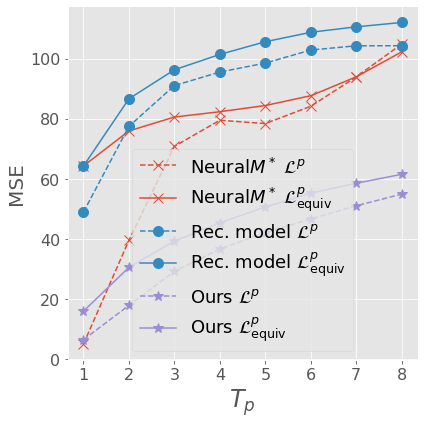

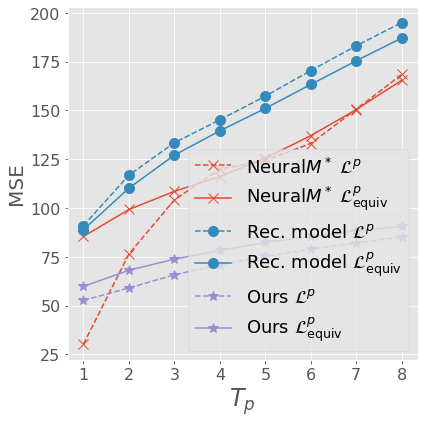

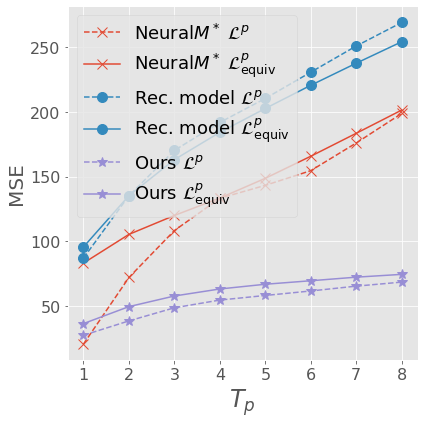

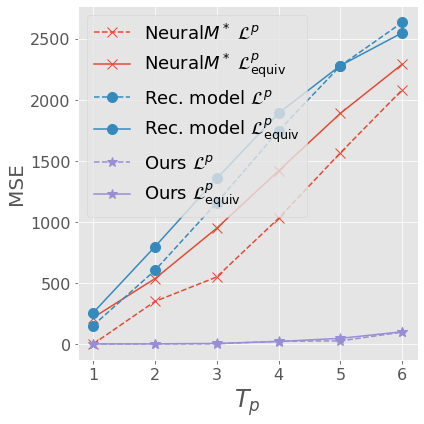

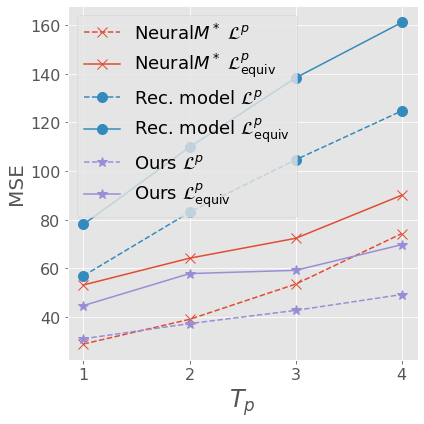

In [40]:
!mkdir figs

for dataset_name in dataset_names:
    label_name= {'neural_trans':'Neural transition', 'neuralM':'Neural$M^*$',
                'lstsq_rec':'Rec. model', 'lstsq_multi':'Ours w/fixed blocks', 'lstsq': 'Ours'}
    l_styles = ['x', 'o', '*']

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    cs=colors
    plt.style.use('ggplot')
    plt.figure(figsize=[6, 6])
    for i, model_name in enumerate(model_names):
        v = equiv_errors[dataset_name][model_name][0][0]
        T = len(v)
        plt.plot(np.arange(1, T+1), 
                    v, '--' + l_styles[i], label=label_name[model_name] + " $\mathcal{L}^p$",
                    c=cs[i], markersize=10)
        v = equiv_errors[dataset_name][model_name][0][1]
        T = len(v)
        plt.plot(np.arange(1, T+1), 
                    v,'-' + l_styles[i], label=label_name[model_name] + " $\mathcal{L}^p_{\\rm equiv}$",
                    c=cs[i], markersize=10)
    
    plt.legend(fontsize=18)    
     
    plt.xticks(np.arange(1, T+1, 1 + (T+1)//10), fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('$T_p$', fontsize=24)
    plt.ylabel('MSE', fontsize=20)
    plt.tight_layout()
    plt.savefig('figs/equiv_error_{}.pdf'.format(dataset_name))


In [41]:
errors_at_Tp_1 = {}
for dataset_name in dataset_names:
    errors_at_Tp_1[dataset_name] = {}
    for model_name in model_names:
        v = equiv_errors[dataset_name][model_name]
        errors_at_Tp_1[dataset_name][model_name] =[[v[0][0][0], v[1][0][0]], [v[0][1][0], v[1][1][0]]]
        

In [42]:
errors_at_Tp_1

{'mnist': {'neuralM': [[4.9907956, 0.87244153], [64.24977, 2.5927525]],
  'lstsq_rec': [[48.906414, 4.4654827], [64.22068, 5.687418]],
  'lstsq': [[6.417885, 0.20565744], [15.907387, 0.49303398]]},
 'mnist_bg': {'neuralM': [[30.320524, 0.35647157], [85.464386, 2.6638145]],
  'lstsq_rec': [[91.02035, 2.2221959], [88.92734, 2.8894563]],
  'lstsq': [[52.672195, 0.8633276], [59.871994, 1.3724878]]},
 'mnist_bg_full': {'neuralM': [[20.60069, 0.24580269], [83.17683, 2.5034628]],
  'lstsq_rec': [[87.05079, 3.320023], [95.658516, 7.714249]],
  'lstsq': [[27.375854, 0.13882276], [36.41506, 0.07674308]]},
 '3dshapes': {'neuralM': [[2.0945506, 0.11882112], [217.72878, 46.686275]],
  'lstsq_rec': [[153.39299, 24.11304], [258.19687, 25.821527]],
  'lstsq': [[2.7498376, 0.2505627], [2.8676271, 0.29988694]]},
 'smallNORB': {'neuralM': [[28.9768, 1.2459692], [53.242664, 0.6417661]],
  'lstsq_rec': [[57.006073, 2.6932602], [78.13729, 4.424154]],
  'lstsq': [[31.139368, 0.51738775], [44.77064, 0.3809766

In [24]:
n_cond = 5

shared_transition = True
equiv_errors = {}
dataset_names = ['mnist_accl']
model_names = ['holstsq']

for dataset_name in dataset_names:
    equiv_errors[dataset_name] = {}
    rng = np.random.RandomState(1)
    if dataset_name == 'mnist_accl':
        T = 20       
        test_data = SequentialMNIST(
            datadir_root, False, T=T,         
            max_angle_velocity_ratio=[-0.2, 0.2],
            max_angle_accl_ratio=[-0.025, 0.025],
            max_color_velocity_ratio=[-0.2, 0.2],
            max_color_accl_ratio=[-0.025, 0.025],
            max_pos=[-0, 0.],
            max_trans_accl=[0.0, 0.0],
            max_T=T,
            only_use_digit4=True,
            backgrnd=False,
            shared_transition=True,
            rng=rng)
    else:
        raise NotImplementedError

    n_rolls = T - n_cond
    
    for model_name in model_names:
        bsize = 32
        test_loader = DataLoader(test_data, bsize, True, num_workers=0)
        
        results = []
        for seed in [1, 2, 3]: 
            path = os.path.join(logdir_root, "{}-{}-seed{}".format(dataset_name, model_name, seed))
            config = load_config(os.path.join(path, 'config.yml'))
            model = yu.load_component(config['model'])
            model.to(device)
            load_model(model, path, iters=config['max_iteration'])
            model.eval()
            count =0
            losses = []
            losses_perm = []
            
            with torch.no_grad():
                for images in tqdm(test_loader):
                    images = torch.stack(images).transpose(1,0)
                    images = images.to(device)
                    (loss, loss_perm), (images_pred, images_pred_perm) = model.loss_equiv(images, n_cond, return_generated_images=True)
                    losses.append(loss)
                    losses_perm.append(loss_perm)
                    count += 1
                    test_data.init_shared_transition_parameters()
            results.append([np.mean(np.concatenate(losses), 0), np.mean(np.concatenate(losses_perm), 0)])
        equiv_errors[dataset_name][model_name] = [np.mean(np.array(results), 0), np.std(np.array(results), 0)]

100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mkdir: cannot create directory ‘figs’: File exists


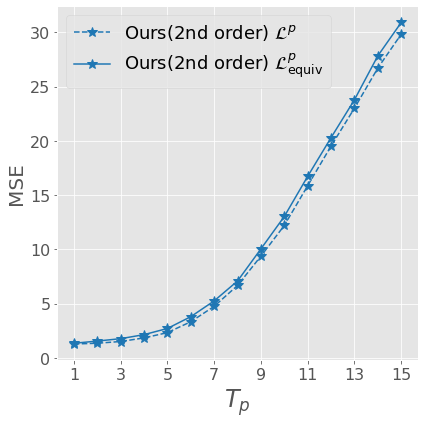

In [25]:
!mkdir figs

for dataset_name in dataset_names:
    label_name= {'holstsq': 'Ours(2nd order)', }
    l_styles = ['*']

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    cs=colors
    plt.style.use('ggplot')
    plt.figure(figsize=[6, 6])
    for i, model_name in enumerate(model_names):
        v = equiv_errors[dataset_name][model_name][0][0]
        T = len(v)
        plt.plot(np.arange(1, T+1), 
                    v, '--' + l_styles[i], label=label_name[model_name] + " $\mathcal{L}^p$",
                    c=cs[i], markersize=10)
        v = equiv_errors[dataset_name][model_name][0][1]
        T = len(v)
        plt.plot(np.arange(1, T+1), 
                    v,'-' + l_styles[i], label=label_name[model_name] + " $\mathcal{L}^p_{\\rm equiv}$",
                    c=cs[i], markersize=10)
    
    plt.legend(fontsize=18)    
     
    plt.xticks(np.arange(1, T+1, 1 + (T+1)//10), fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('$T_p$', fontsize=24)
    plt.ylabel('MSE', fontsize=20)
    plt.tight_layout()
    plt.savefig('figs/equiv_error_{}.pdf'.format(dataset_name))


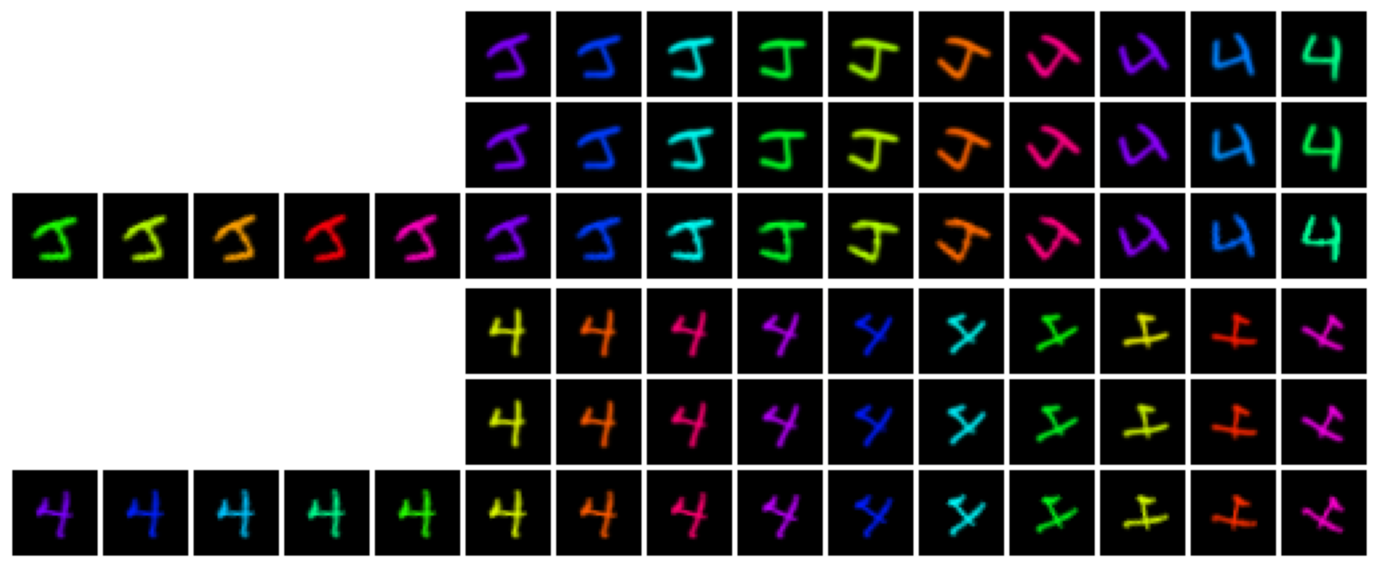

In [23]:
save_images(images[:5, :n_cond], images[:5, n_cond:n_cond+10], images_pred[:5, :10], images_pred_perm[:5, :10], 'equiv_images', n_col=1)

In [26]:
errors_at_Tp_1 = {}
for dataset_name in dataset_names:
    errors_at_Tp_1[dataset_name] = {}
    for model_name in model_names:
        v = equiv_errors[dataset_name][model_name]
        errors_at_Tp_1[dataset_name][model_name] =[[v[0][0][0], v[1][0][0]], [v[0][1][0], v[1][1][0]]]
        

In [27]:
errors_at_Tp_1

{'mnist_accl': {'holstsq': [[1.2696251, 0.015808318],
   [1.3368932, 0.029605374]]}}